In [1]:
import os
import math
import glob
import torch
import random
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
from tqdm.auto import tqdm
from torch.optim import Adam
from torchinfo import summary
from torchvision.models import vgg19
from torchvision.transforms import v2
from torch.nn.utils import spectral_norm
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchmetrics.image import PeakSignalNoiseRatio
from torchmetrics.image import StructuralSimilarityIndexMeasure
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
HR_train_paths = sorted(glob.glob("../data/DIV2K/DIV2K_train_HR/*.png"))
X2_train_paths = sorted(glob.glob("../data/DIV2K/DIV2K_train_LR_bicubic/X2/*.png"))
X4_train_paths = sorted(glob.glob("../data/DIV2K/DIV2K_train_LR_bicubic/X4/*.png"))
X8_train_paths = sorted(glob.glob("../data/DIV2K/DIV2K_train_LR_bicubic/X8/*.png"))
X16_train_paths = sorted(glob.glob("../data/DIV2K/DIV2K_train_LR_bicubic/X16/*.png"))
X32_train_paths = sorted(glob.glob("../data/DIV2K/DIV2K_train_LR_bicubic/X32/*.png"))
X64_train_paths = sorted(glob.glob("../data/DIV2K/DIV2K_train_LR_bicubic/X64/*.png"))

HR_valid_paths = sorted(glob.glob("../data/DIV2K/DIV2K_valid_HR/*.png"))
X2_valid_paths = sorted(glob.glob("../data/DIV2K/DIV2K_valid_LR_bicubic/X2/*.png"))
X4_valid_paths = sorted(glob.glob("../data/DIV2K/DIV2K_valid_LR_bicubic/X4/*.png"))
X8_valid_paths = sorted(glob.glob("../data/DIV2K/DIV2K_valid_LR_bicubic/X8/*.png"))
X16_valid_paths = sorted(glob.glob("../data/DIV2K/DIV2K_valid_LR_bicubic/X16/*.png"))
X32_valid_paths = sorted(glob.glob("../data/DIV2K/DIV2K_valid_LR_bicubic/X32/*.png"))
X64_valid_paths = sorted(glob.glob("../data/DIV2K/DIV2K_valid_LR_bicubic/X64/*.png"))

## Generator - EDSR with RRDB

In [4]:
class DenseBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.blocks = nn.Sequential()
        for i in range(1,5):
            self.blocks.append(
                nn.Sequential(
                    nn.Conv2d(i * 64, 64, 3, stride=1, padding='same'),
                    nn.LeakyReLU()
                )
            )

        self.blocks.append(nn.Conv2d(5 * 64, 64, 3, stride=1, padding='same'))

    def forward(self, x):
        x1 = self.blocks[0](x)
        x = torch.cat([x, x1], dim=1)
        x2 = self.blocks[1](x)
        x = torch.cat([x, x2], dim=1)
        x3 = self.blocks[2](x)
        x = torch.cat([x, x3], dim=1)
        x4 = self.blocks[3](x)
        x = torch.cat([x, x4], dim=1)
        return self.blocks[4](x)
        
class ESRGAN(nn.Module):
    def __init__(self, n: int):
        """
        Enhanced Deep Residual Network with Residual in Residual Dense Block a.k.a.
        Enhanced Super Resolution Generative Adversarial Networks
        Args:
            n: scaling factor
        """
        super().__init__()
        self.DIV2K_RGB = torch.tensor([0.44882884613943946, 0.43713809810624193, 0.4040371984052683]).view(1, 3, 1, 1).to(device)
        
        self.expand = nn.Sequential(
            nn.Conv2d(3, 64, 9, stride=1, padding='same'),
            nn.PReLU()
        )

        self.residual_blocks = nn.Sequential()
        for _ in range(23):
            self.residual_blocks.append(DenseBlock())

        self.residual_blocks.append(nn.Conv2d(64, 64, 3, stride=1, padding='same'))

        self.upscaling_head = nn.Sequential()
        for _ in range(int(math.log2(n))):
            self.upscaling_head.append(nn.Conv2d(64, 256, 3, stride=1, padding='same'))
            self.upscaling_head.append(nn.PixelShuffle(2))
            self.upscaling_head.append(nn.PReLU())
            
        self.upscaling_head.append(nn.Conv2d(64, 64, 9, stride=1, padding='same'))
        self.upscaling_head.append(nn.Conv2d(64, 3, 9, stride=1, padding='same'))

    def forward(self, x):
        x = self.expand(x-self.DIV2K_RGB)
        xp = x.clone()
        for i in range(23):
            xp = xp + 0.2 * self.residual_blocks[i](xp)

        x = x + 0.2 * self.residual_blocks[23](xp)
        return self.upscaling_head(x) + self.DIV2K_RGB

In [5]:
summary(ESRGAN(2), input_size=(16, 3, 48, 48))

Layer (type:depth-idx)                        Output Shape              Param #
ESRGAN                                        [16, 3, 96, 96]           --
├─Sequential: 1-1                             [16, 64, 48, 48]          --
│    └─Conv2d: 2-1                            [16, 64, 48, 48]          15,616
│    └─PReLU: 2-2                             [16, 64, 48, 48]          1
├─Sequential: 1-2                             --                        --
│    └─DenseBlock: 2-3                        [16, 64, 48, 48]          --
│    │    └─Sequential: 3-1                   --                        553,280
│    └─DenseBlock: 2-4                        [16, 64, 48, 48]          --
│    │    └─Sequential: 3-2                   --                        553,280
│    └─DenseBlock: 2-5                        [16, 64, 48, 48]          --
│    │    └─Sequential: 3-3                   --                        553,280
│    └─DenseBlock: 2-6                        [16, 64, 48, 48]          --
│ 

## Discriminator

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, ni: int, nf: int, ks: int, stride: int):
        super().__init__()
        
        self.block = nn.Sequential(
            spectral_norm(nn.Conv2d(ni, nf, ks, stride=stride, padding=1)),
            nn.LeakyReLU(negative_slope=0.2)
        )

    def forward(self, x):
        return self.block(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.expand = nn.Sequential(
            spectral_norm(nn.Conv2d(3, 64, 3, stride=1, padding=1)),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.body = nn.Sequential(
            ConvBlock(64, 64, 3, 2),
            ConvBlock(64, 128, 3, 1),
            ConvBlock(128, 128, 3, 2),
            ConvBlock(128, 256, 3, 1),
            ConvBlock(256, 256, 3, 2),
            ConvBlock(256, 512, 3, 1),
            ConvBlock(512, 512, 3, 2)
        )

        self.avgpool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

        self.head = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(1024, 1)
        )

        self.model = nn.Sequential(
            self.expand,
            self.body,
            self.avgpool,
            self.head   
        )

    def forward(self, x):
        return self.model(x)

class RaD(nn.Module):
    """
    Relativistic average Discriminator
    """
    def __init__(self):
        super().__init__()
        self.discriminator = Discriminator()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):
        return self.sigmoid(self.discriminator(x1) - self.discriminator(x2).mean(dim=0, keepdim=True))

In [7]:
summary(Discriminator(), input_size=(16, 3, 96, 96))

Layer (type:depth-idx)                        Output Shape              Param #
Discriminator                                 [16, 1]                   --
├─Sequential: 1-1                             [16, 1]                   --
│    └─Sequential: 2-1                        [16, 64, 96, 96]          --
│    │    └─Conv2d: 3-1                       [16, 64, 96, 96]          1,792
│    │    └─LeakyReLU: 3-2                    [16, 64, 96, 96]          --
│    └─Sequential: 2-2                        [16, 512, 6, 6]           --
│    │    └─ConvBlock: 3-3                    [16, 64, 48, 48]          36,928
│    │    └─ConvBlock: 3-4                    [16, 128, 48, 48]         73,856
│    │    └─ConvBlock: 3-5                    [16, 128, 24, 24]         147,584
│    │    └─ConvBlock: 3-6                    [16, 256, 24, 24]         295,168
│    │    └─ConvBlock: 3-7                    [16, 256, 12, 12]         590,080
│    │    └─ConvBlock: 3-8                    [16, 512, 12, 12]      

## VGG - Content loss function

In [8]:
vgg = vgg19(weights=torchvision.models.VGG19_Weights.DEFAULT).to(device)

In [9]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [10]:
vgg54 = vgg.features[:35]
vgg54.eval();

vgg_transform = torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms()

In [5]:
class ESRGAN_Dataset(Dataset):
    def __init__(self, target_paths: list[str], scale: int, ram_limit_gb: float = 2.0):
        self.crop_size = scale * 48
        self.scale = scale

        self.rotations = [0, 90, 180, 270]
        self.transforms = v2.Compose([
            v2.PILToTensor(),
            v2.Lambda(lambda x: (x / 255.0))
        ])

        self.preloaded = {}
        self.paths = target_paths

        total_ram_used = 0
        for i, path in enumerate(tqdm(target_paths, desc="Preloading images")):
            img = Image.open(path).convert("RGB")
            total_ram_used += img.width * img.height * 3 / (1024 ** 3)  # ~size in GB

            if total_ram_used < ram_limit_gb:
                self.preloaded[i] = img
            else:
                break

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        if idx in self.preloaded:
            target = self.preloaded[idx]
        else:
            target = Image.open(self.paths[idx]).convert("RGB")

        target = self.random_crop(target, self.crop_size)
        inp = target.resize((target.width // self.scale, target.height // self.scale), Image.BICUBIC)
        
        rotation =  random.choice(self.rotations)
        if rotation != 0:
            inp = v2.functional.rotate(inp, rotation)
            target = v2.functional.rotate(target, rotation)
        if random.randint(0, 1):
            inp = v2.functional.horizontal_flip(inp)
            target = v2.functional.horizontal_flip(target)
            
        return self.transforms(inp), self.transforms(target)

    def random_crop(self, img, size):
        w, h = img.size
        if w < size or h < size:
            img = img.resize((size, size), Image.BICUBIC)
        x = random.randint(0, w - size)
        y = random.randint(0, h - size)
        return img.crop((x, y, x + size, y + size))

    def set_scale(self, scale: int):
        self.scale = scale

    def set_crop_size(self, crop_size: int):
        self.crop_size = crop_size

In [14]:
psnr = PeakSignalNoiseRatio(data_range=1.0).to(device)
ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
lpips = LearnedPerceptualImagePatchSimilarity(normalize=True).to(device)

In [5]:
transform = v2.Compose([
    v2.PILToTensor(),
    v2.Lambda(lambda x: x / 255.0)
])

In [16]:
def calc_metrics(model: nn.Module, target_ds: list[str], scale: int):
    transform_target = v2.Compose([
        v2.PILToTensor(),
        v2.Lambda(lambda x: x / 255.0)
    ])

    transform_input = v2.Compose([
        v2.PILToTensor(),
        v2.Lambda(lambda x: (x / 255.0))
    ])

    psnr_acc = 0
    ssim_acc = 0
    lpips_acc = 0
    failed_lpips = 0

    for i in tqdm(range(len(target_ds)), leave=False):
        target_image = Image.open(target_ds[i]).convert("RGB")
        w, h = target_image.size

        w -= w % scale
        h -= h % scale
        target_image = target_image.crop((0, 0, w, h))
        
        lowres = target_image.resize((w // scale, h // scale), resample=Image.BICUBIC)
        input_tensor = transform_input(lowres).unsqueeze(0).to(device)
        target_tensor = transform_target(target_image).unsqueeze(0).to(device)

        with torch.inference_mode():
            sr = model(input_tensor).clamp(0, 1)

        psnr_acc += psnr(sr, target_tensor).item()
        ssim_acc += ssim(sr, target_tensor).item()
        
        # There are 2 images that cause lpips to fail
        try:
            x = lpips(sr, target_tensor).cpu().item()
            if np.isnan(x):
                failed_lpips += 1
                continue
                
            lpips_acc += x
        except:
            failed_lpips += 1

    lpips_acc /= len(target_ds) - failed_lpips
    psnr_acc /= len(target_ds)
    ssim_acc /= len(target_ds)
    return psnr_acc, ssim_acc, lpips_acc

In [17]:
def train_generator(batch, xr, generator, discriminator, optimizer, scaler, l1_loss):
    eta = 0.01
    lmbda = 0.005
    generator.train()
    discriminator.eval()
    
    optimizer.zero_grad(set_to_none=True)

    with autocast('cuda'):
        xf = generator(batch)

        d_xf_xr = discriminator(xf, xr)
        d_xr_xf = discriminator(xr, xf)

        eps = 1e-2
        d_xf_xr = d_xf_xr.clamp(eps, 1 - eps)
        d_xr_xf = d_xr_xf.clamp(eps, 1 - eps)
        
        RaD_loss = - torch.log(1 - d_xr_xf).mean() - torch.log(d_xf_xr).mean()
        
        loss = torch.mean((vgg54(vgg_transform(xr)) - vgg54(vgg_transform(xf)))**2) + lmbda * RaD_loss + eta * l1_loss(xf, xr)

        if loss == float('inf'):
            print(f"RAD: {RaD_loss} | L1:  {l1_loss(xf, xr)} | VGG: {vgg54(vgg_transform(xr)) - vgg54(vgg_transform(xf))}")

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    return loss.item()

def train_discriminator(LR, xr, generator, discriminator, optimizer):
    generator.eval()
    discriminator.train()
    optimizer.zero_grad(set_to_none=True)
    
    with torch.no_grad():
        xf = generator(LR).detach()

    d_xf_xr = discriminator(xf, xr)
    d_xr_xf = discriminator(xr, xf)

    eps = 1e-4
    d_xf_xr = d_xf_xr.clamp(eps, 1 - eps)
    d_xr_xf = d_xr_xf.clamp(eps, 1 - eps)

    loss = - torch.log(d_xr_xf).mean() - torch.log(1 - d_xf_xr).mean()

    loss.backward()
    optimizer.step()
    
    return loss.item()

In [18]:
def train_step(generator, discriminator, dataloader, generator_opt, discriminator_opt, l1_loss, generator_scaler):
    discriminator_loss = 0
    generator_loss = 0
    
    for batch, target in dataloader:
        batch, target = batch.to(device), target.to(device)
        discriminator_loss += train_discriminator(batch, target, generator, discriminator, discriminator_opt)
        generator_loss += train_generator(batch, target, generator, discriminator, generator_opt, generator_scaler, l1_loss)
        
    discriminator_loss /= len(dataloader)
    generator_loss /= len(dataloader)
    return discriminator_loss, generator_loss

def valid_step(generator, discriminator, dataloader, l1_loss):
    eta = 0.01
    lmbda = 0.005
    generator.eval()
    discriminator.eval()
    discriminator_loss = 0
    generator_loss = 0
    lpips_acc = 0

    with torch.inference_mode():
        for batch, target in dataloader:
            batch, xr = batch.to(device), target.to(device)
            
            xf = generator(batch)
            lpips_acc += lpips(((xf+1.0)/2.0).clamp(0.0, 1.0), ((xr+1.0)/2.0).clamp(0.0, 1.0))

            RaD_loss = - torch.log(1 - discriminator(xr, xf) + 1e-12).mean() - torch.log(discriminator(xf, xr) + 1e-12).mean()
            generator_loss += (torch.mean((vgg54(vgg_transform(xr)) - vgg54(vgg_transform(xf)))**2) + lmbda * RaD_loss + eta * l1_loss(xf, xr)).item()

            discriminator_loss += (- torch.log(discriminator(xr, xf) + 1e-12).mean() - torch.log(1 - discriminator(xf, xr) + 1e-12).mean()).item()
        
        discriminator_loss /= len(dataloader) 
        generator_loss /= len(dataloader)
        lpips_acc /= len(dataloader)


    return discriminator_loss, generator_loss, lpips_acc

In [19]:
def train(generator, discriminator, train_dl, valid_dl, generator_opt, discriminator_opt, generator_scheduler: StepLR, 
          discriminator_scheduler: StepLR, l1_loss, epochs, start_checkpoint=None):
    os.makedirs('../tmp_model_checkpoints', exist_ok=True)
    counter = 0 # count epochs without printing training stats
    best_lpips= float('inf')
    generator_scaler = GradScaler('cuda')
    
    if start_checkpoint:
        start_epoch = start_checkpoint['epoch'] + 1
        best_lpips = start_checkpoint['lpips']
        generator_scaler.load_state_dict(start_checkpoint['generator_scaler_state_dict'])
    else:
        start_epoch = 0
        
    log_freq = (epochs - start_epoch) // 100 # how often to print stats when no progress is made
        
    for epoch in tqdm(range(start_epoch, epochs), desc="Epochs"):
        counter += 1
        train_d_loss, train_g_loss = train_step(
            generator,
            discriminator,
            train_dl,
            generator_opt,
            discriminator_opt,
            l1_loss,
            generator_scaler
        )

        valid_d_loss, valid_g_loss, valid_lpips = valid_step(
            generator,
            discriminator,
            valid_dl,
            l1_loss
        )
        if epoch+1 in [int(0.1*epochs), int(0.2*epochs), int(0.4*epochs), int(0.6*epochs)]:
            discriminator_scheduler.step()
            generator_scheduler.step()

        progress = False
        
        if valid_lpips < best_lpips:
            progress = True
            best_lpips = valid_lpips
            checkpoint = {
                'epoch': epoch,
                'lpips': best_lpips,
                'discriminator_state_dict': discriminator.discriminator.state_dict(),
                'generator_state_dict': generator.state_dict(),
                'discriminator_optimizer_state_dict': discriminator_opt.state_dict(),
                'generator_optimizer_state_dict': generator_opt.state_dict(),
                'discriminator_scheduler_state_dict': discriminator_scheduler.state_dict(),
                'generator_scheduler_state_dict': generator_scheduler.state_dict(),
                'generator_scaler_state_dict': generator_scaler.state_dict()
            }
            torch.save(checkpoint, f'../tmp_model_checkpoints/best.pth')

        if epoch == epochs-1:
            checkpoint = {
                'epoch': epoch,
                'lpips': best_lpips,
                'discriminator_state_dict': discriminator.discriminator.state_dict(),
                'generator_state_dict': generator.state_dict(),
                'discriminator_optimizer_state_dict': discriminator_opt.state_dict(),
                'generator_optimizer_state_dict': generator_opt.state_dict(),
                'discriminator_scheduler_state_dict': discriminator_scheduler.state_dict(),
                'generator_scheduler_state_dict': generator_scheduler.state_dict(),
                'generator_scaler_state_dict': generator_scaler.state_dict()
            }
            torch.save(checkpoint, f'../tmp_model_checkpoints/last.pth')
            
        if True or progress or counter >= log_freq:
            counter = 0
            print(
                f"Epoch: {epoch+1} | "
                f"learning rate: {generator_scheduler.get_last_lr()[0]:.6f} | "
                f"[train] generator: {train_g_loss:.4f} | "
                f"[train] discriminator: {train_d_loss:.4f} | "
                f"[valid] generator: {valid_g_loss:.4f} | "
                f"[valid] discriminator: {valid_d_loss:.4f} | "
                f"[valid] lpips: {valid_lpips:.4f}"
            )

        # Store intermediate results to see how training goes
        if (epoch + 350) % 400 == 0:
            inp = transform(Image.open(X4_valid_paths[4])).to(device)
            with torch.inference_mode():
                out = (generator(inp[None]).clamp(0.0, 1.0) * 255.0).squeeze()
            
            img = Image.fromarray(out.permute(1, 2, 0).to(torch.uint8).cpu().numpy())
            os.makedirs('./mid_training_images/', exist_ok=True)
            img.save(f'./mid_training_images/{epoch}_img1.png')
            
            inp = transform(Image.open(X4_valid_paths[52]).convert("RGB")).to(device)
            with torch.inference_mode():
                out = (generator(inp[None]).clamp(0.0, 1.0) * 255.0).squeeze()
            
            img = Image.fromarray(out.permute(1, 2, 0).to(torch.uint8).cpu().numpy())
            img.save(f'./mid_training_images/{epoch}_img2.png')
            
            inp = transform(Image.open('/home/noNScop/Desktop/projects/test.png').convert("RGB")).to(device)
            with torch.inference_mode():
                out = (generator(inp[None]).clamp(0.0, 1.0) * 255.0).squeeze()
            
            img = Image.fromarray(out.permute(1, 2, 0).to(torch.uint8).cpu().numpy())
            img.save(f'./mid_training_images/{epoch}_img3.png')

## X2 Scaling

In [18]:
valid_ds = ESRGAN_Dataset(HR_valid_paths, 2, ram_limit_gb=1)

Preloading images:   0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
train_ds = ESRGAN_Dataset(HR_train_paths, 2, ram_limit_gb=8)

Preloading images:   0%|          | 0/800 [00:00<?, ?it/s]

In [20]:
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=os.cpu_count()-1)
valid_dl = DataLoader(valid_ds, batch_size=16, shuffle=False, num_workers=os.cpu_count()-1)

l1_loss = nn.L1Loss()

In [21]:
checkpoint = torch.load('./ESRGAN_pretrained_X2.pth')
generator = ESRGAN(2).to(device)
generator.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [22]:
discriminator = RaD().to(device)

### Discriminator warm-up

In [24]:
# discriminator_opt = Adam(discriminator.parameters(), lr=1e-4)

# for epoch in tqdm(range(100), desc="Discriminator warm up"):
#     train_d_loss = 0
#     for batch, target in train_dl:
#         batch, target = batch.to(device), target.to(device)
#         train_d_loss += train_discriminator(batch, target, generator, discriminator, discriminator_opt)

#     train_d_loss /= len(train_dl)
        
#     valid_d_loss, _, _ = valid_step(generator, discriminator, valid_dl, l1_loss)
    
#     if (epoch) % 1 == 0:
#         print(
#             f"Epoch: {epoch+1} | "
#             f"[train] discriminator: {train_d_loss:.6f} | "
#             f"[valid] discriminator: {valid_d_loss:.6f} | "
#         )

# torch.save(
#     {
#         "discriminator_state_dict": discriminator.state_dict(),
#     },
#     "discriminator_warmup.pth"
# )

# print(f"Discriminator warm-up checkpoint saved to: {ckpt_path}")

In [25]:
# ckpt_path = "discriminator_warmup.pth"

# checkpoint = torch.load("discriminator_warmup.pth", map_location=device)

# discriminator.load_state_dict(checkpoint["discriminator_state_dict"])

# start_epoch = checkpoint["epoch"]

# print(f"Loaded discriminator warm-up checkpoint (epoch {start_epoch})")

In [23]:
generator_opt = Adam(generator.parameters(), lr=1e-4)
discriminator_opt = Adam(discriminator.parameters(), lr=1e-4)

generator_scheduler = StepLR(generator_opt, step_size=1, gamma=0.5)
discriminator_scheduler = StepLR(discriminator_opt, step_size=1, gamma=0.5)

In [27]:
train(generator, discriminator, train_dl, valid_dl, generator_opt, discriminator_opt, generator_scheduler, discriminator_scheduler, l1_loss, 1500)

Epochs:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch: 1 | learning rate: 0.000100 | [train] generator: 0.5070 | [train] discriminator: 1.3541 | [valid] generator: 0.5181 | [valid] discriminator: 1.4825 | [valid] lpips: 0.0293
Epoch: 2 | learning rate: 0.000100 | [train] generator: 0.4171 | [train] discriminator: 1.3418 | [valid] generator: 0.4878 | [valid] discriminator: 1.3884 | [valid] lpips: 0.0309
Epoch: 3 | learning rate: 0.000100 | [train] generator: 0.4453 | [train] discriminator: 1.2471 | [valid] generator: 0.5159 | [valid] discriminator: 1.4195 | [valid] lpips: 0.0336
Epoch: 4 | learning rate: 0.000100 | [train] generator: 0.4401 | [train] discriminator: 1.1530 | [valid] generator: 0.4271 | [valid] discriminator: 0.6835 | [valid] lpips: 0.0310
Epoch: 5 | learning rate: 0.000100 | [train] generator: 0.4582 | [train] discriminator: 1.4233 | [valid] generator: 0.5032 | [valid] discriminator: 1.3842 | [valid] lpips: 0.0339
Epoch: 6 | learning rate: 0.000100 | [train] generator: 0.4422 | [train] discriminator: 1.3845 | [valid] 

In [6]:
checkpoint = torch.load('../model_checkpoints/ESRGAN/X2.pth')
generator = ESRGAN(2).to(device)
generator.load_state_dict(checkpoint['generator_state_dict'])

<All keys matched successfully>

In [7]:
generator.eval();

In [29]:
targets = [X32_valid_paths, X16_valid_paths, X8_valid_paths, X4_valid_paths, X2_valid_paths, HR_valid_paths]

metrics_x2 = pd.DataFrame(columns=["PSNR↑", "SSIM↑", "LPIPS↓"])
for target_ds in tqdm(targets, total=6):
    metrics_x2.loc[len(metrics_x2)] = calc_metrics(generator, target_ds, 2)

metrics_x2.index = [
    "31px -> 62px", "63px -> 126px", "127px -> 254px", 
    "255px -> 510px", "510px -> 1020px", "1020px -> 2040px"
]
metrics_x2

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

PSNR↑     SSIM↑    LPIPS↓
31px -> 62px      25.747864  0.848953  0.025996
63px -> 126px     27.068612  0.871211  0.034883
127px -> 254px    28.937787  0.897411  0.033732
255px -> 510px    30.487443  0.909015  0.032675
510px -> 1020px   32.272818  0.920933  0.031426
1020px -> 2040px  33.330630  0.915227  0.035546

### Super-resolution showcase

31px -> 248px


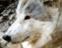

In [38]:
print("31px -> 248px")
inp = transform(Image.open(X64_valid_paths[4])).to(device)
with torch.inference_mode():
    out = (generator(inp[None]).clamp(0.0, 1.0) * 255.0).squeeze()

img = Image.fromarray(out.permute(1, 2, 0).to(torch.uint8).cpu().numpy())
os.makedirs('../image_results/8X/31px', exist_ok=True)
img.save('../image_results/8X/31px/ESRGAN_31px.png')
img

63px -> 126px


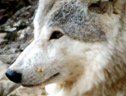

In [39]:
print("63px -> 126px")
inp = transform(Image.open(X32_valid_paths[4])).to(device)
with torch.inference_mode():
    out = (generator(inp[None]).clamp(0.0, 1.0) * 255.0).squeeze()

img = Image.fromarray(out.permute(1, 2, 0).to(torch.uint8).cpu().numpy())
os.makedirs('../image_results/2X/63px', exist_ok=True)
img.save('../image_results/2X/63px/ESRGAN_63px.png')
img

127px -> 254px


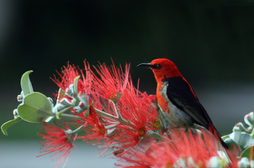

In [24]:
print("127px -> 254px")
inp = transform(Image.open(X16_valid_paths[52])).to(device)
with torch.inference_mode():
    out = (generator(inp[None]).clamp(0.0, 1.0) * 255.0).squeeze()

img = Image.fromarray(out.permute(1, 2, 0).to(torch.uint8).cpu().numpy())
os.makedirs('../image_results/2X/127px', exist_ok=True)
img.save('../image_results/2X/127px/ESRGAN_127px.png')
img

255px -> 510px


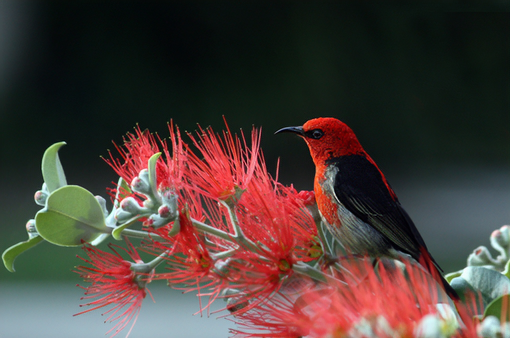

In [22]:
print("255px -> 510px")
inp = transform(Image.open(X8_valid_paths[52])).to(device)
with torch.inference_mode():
    out = (generator(inp[None]).clamp(0.0, 1.0) * 255.0).squeeze()

img = Image.fromarray(out.permute(1, 2, 0).to(torch.uint8).cpu().numpy())
os.makedirs('../image_results/2X/255px', exist_ok=True)
img.save('../image_results/2X/255px/ESRGAN_255px.png')
img

510px -> 1020px


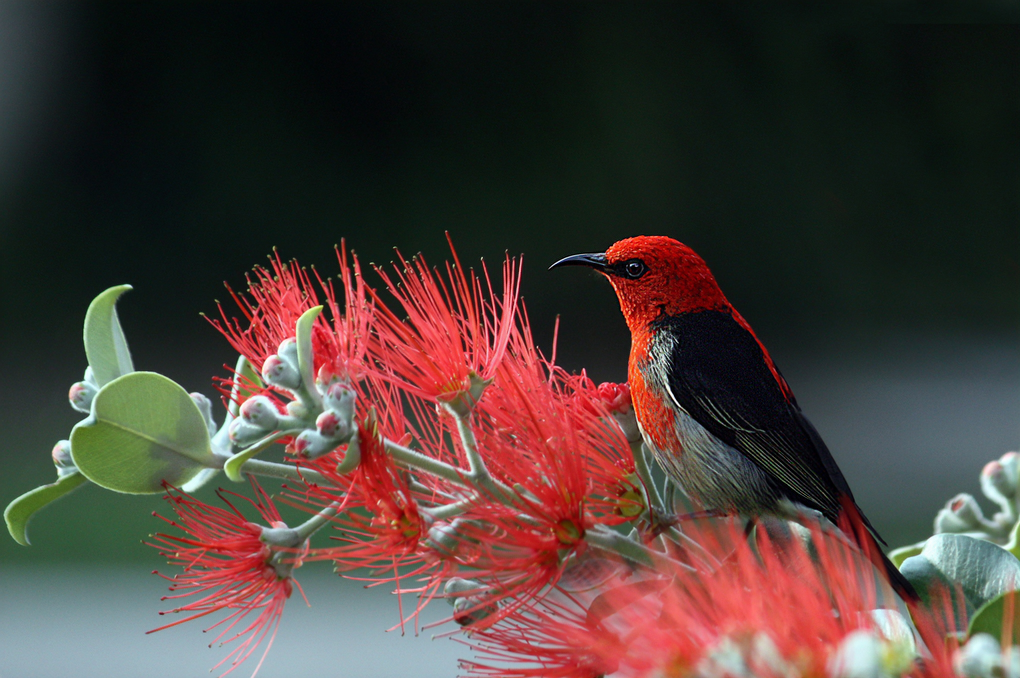

In [23]:
print("510px -> 1020px")
inp = transform(Image.open(X4_valid_paths[52])).to(device)
with torch.inference_mode():
    out = (generator(inp[None]).clamp(0.0, 1.0) * 255.0).squeeze()

img = Image.fromarray(out.permute(1, 2, 0).to(torch.uint8).cpu().numpy())
os.makedirs('../image_results/2X/510px', exist_ok=True)
img.save('../image_results/2X/510px/ESRGAN_510px.png')
img

1020px -> 2040px


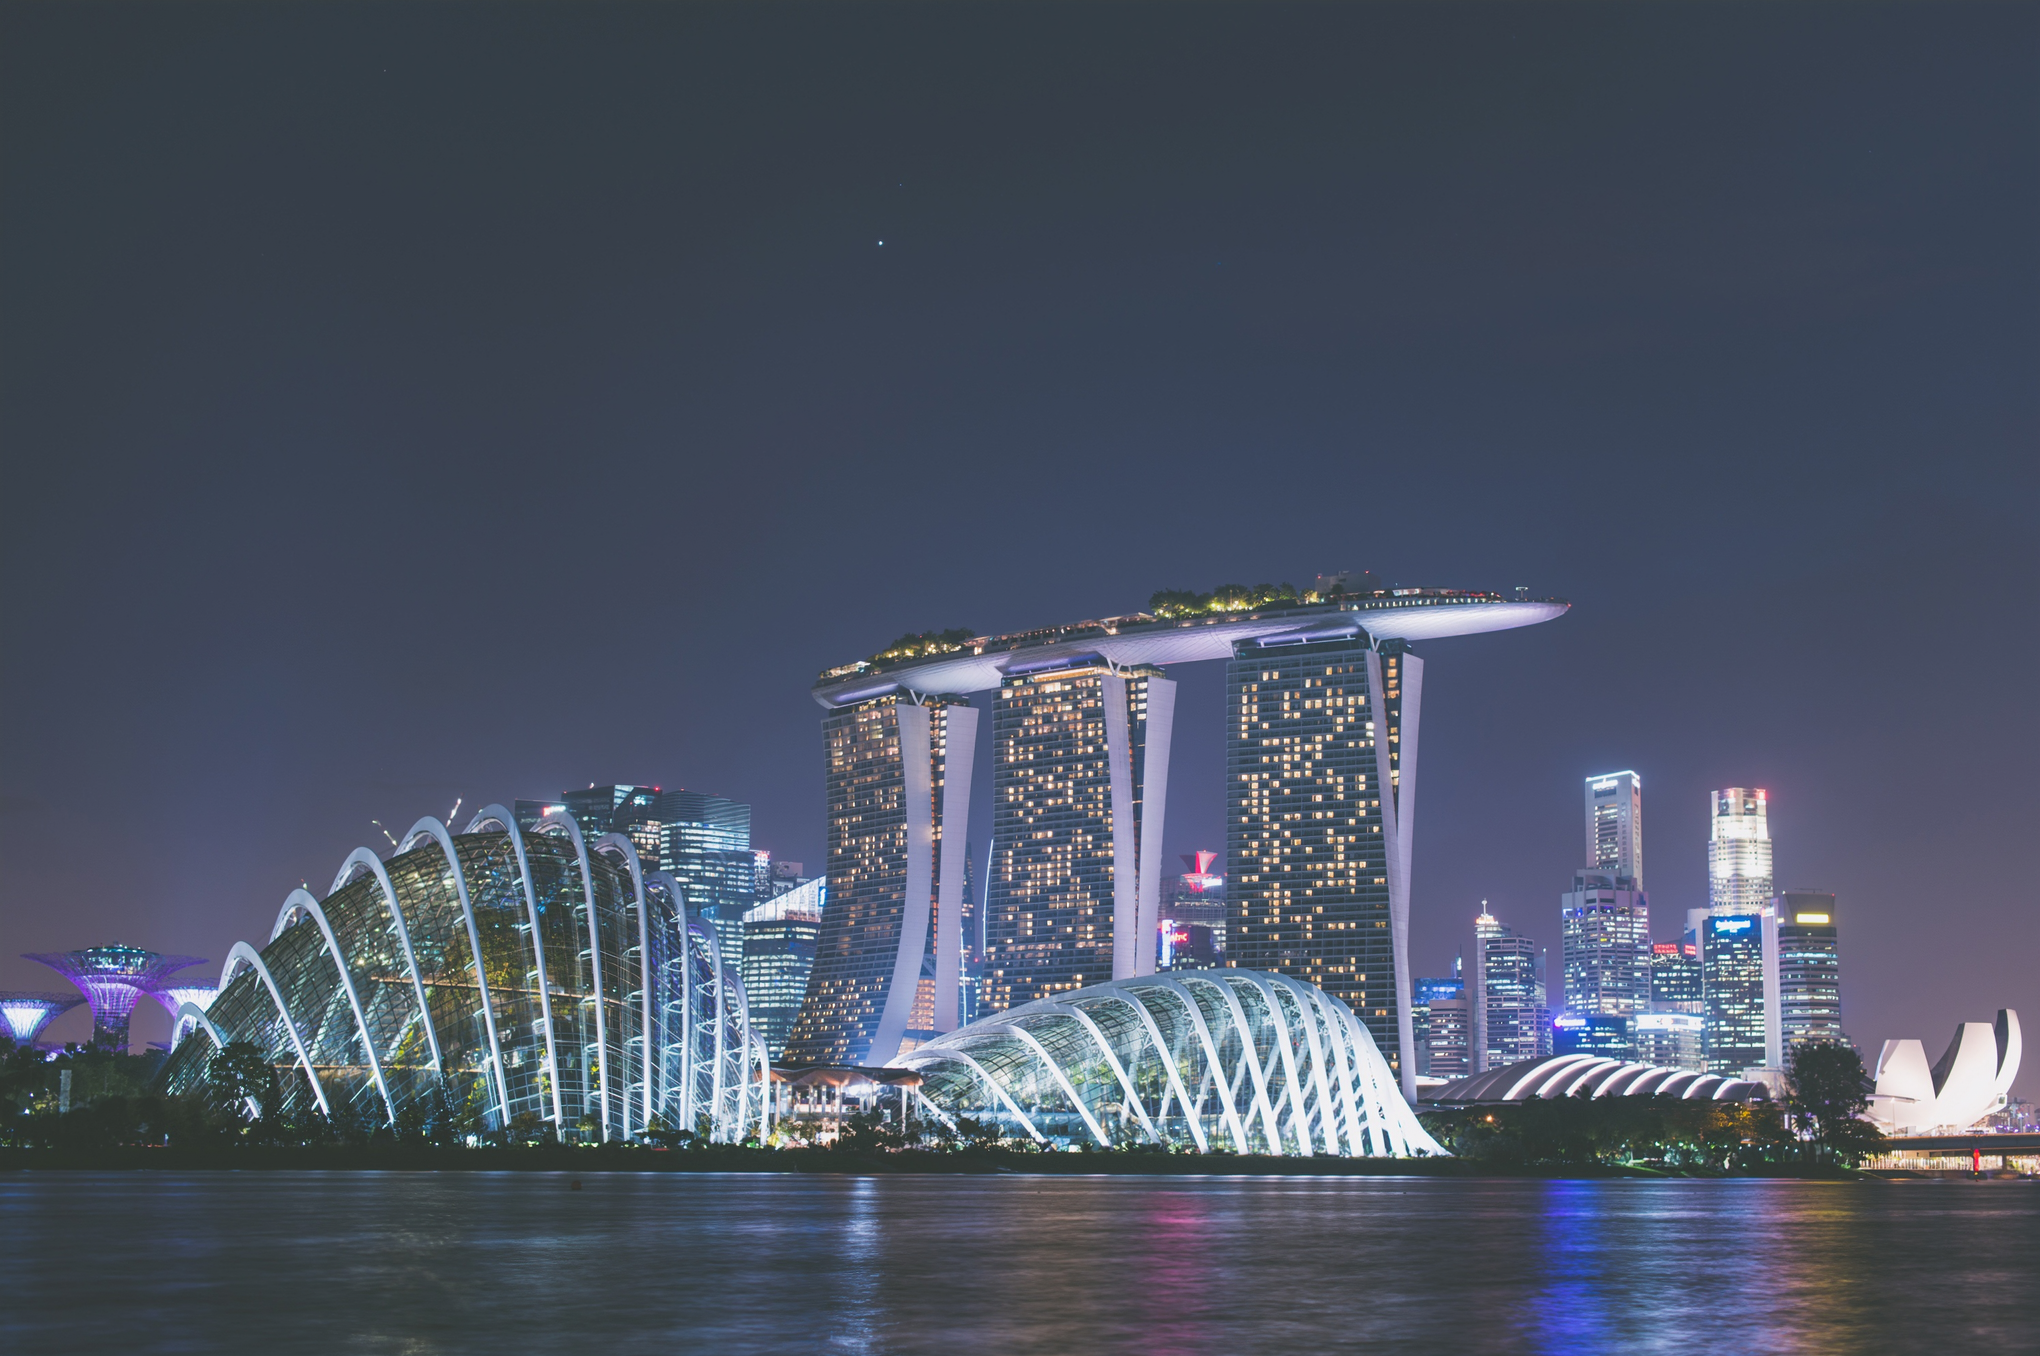

In [10]:
# %%timeit
print("1020px -> 2040px")
inp = transform(Image.open(X2_valid_paths[13])).to(device)
with torch.inference_mode():
    out = (generator(inp[None]).clamp(0.0, 1.0) * 255.0).squeeze()

img = Image.fromarray(out.permute(1, 2, 0).to(torch.uint8).cpu().numpy())
os.makedirs('../image_results/2X/1020px', exist_ok=True)
img.save('../image_results/2X/1020px/ESRGAN_1020px.png')
img